In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import * 
import fastai
import pandas as pd
import torch

In [3]:
path = Path('hushed')
data_path = Path('hushed/texts')

torch.cuda.is_available()

True

In [4]:
train_df = pd.read_csv(f'{data_path}/train.csv')
valid_df = pd.read_csv(f'{data_path}/valid.csv')
unlabeled_df = pd.read_csv(f'{data_path}/unlabeled.csv')

all_df = pd.concat([unlabeled_df, train_df, valid_df])
all_df = all_df.drop('is_valid', axis=1)
all_df = all_df.iloc[np.random.permutation(len(all_df))]

cut = int(0.1 * len(all_df)) + 1
train_df, valid_df = all_df[cut:], all_df[:cut]

/home/isaac/anaconda3/envs/hushed-fastai/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


### Language Model

Create the data bunches that will be used to train our models.

In [5]:
data_lm = TextLMDataBunch.from_df(path, train_df, valid_df, bs=32)
data_lm.save()

In [6]:
unlabeled_df = None
all_df = None
train_df = None
valid_df = None

In [7]:
# Skip loading the texts
# data_lm = TextDataBunch.load(path)

Create our language model with a pre-trained model.

In [8]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

Find our learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


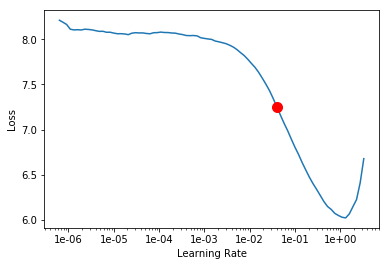

In [9]:
lr_find(learn)
learn.recorder.plot()

Train the layers which are sitting on top of the pre-trained model.

In [10]:
learn.fit(6, lr=[1e-1, 1e-1, 1e-2, 1e-2])

epoch,train_loss,valid_loss,accuracy
1,2.381490,1.984998,0.682236
2,2.154532,1.892859,0.691927
3,2.049118,1.862811,0.695629
4,2.018850,1.848133,0.698521
5,1.975986,1.841459,0.699563
6,1.938999,1.840084,0.699275


Unfreeze the pre-trained model and train the entire stack

In [11]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.750277,1.782057,0.707617


In [12]:
learn.save_encoder('ft_enc')

In [13]:
learn.predict("your facebook verification code", n_words=6)

'your facebook verification code is THESIS xxbos Your'

### Classifier

Create the text clasififer model which will use the language model to read the texts.

In [4]:
learn = load_learner(path)
learn.predict("Yo when are we meeting?")

(Category good, tensor(0), tensor([9.9876e-01, 9.6238e-04, 2.8109e-04]))

In [14]:
train_df = pd.read_csv(f'{data_path}/train.csv')
valid_df = pd.read_csv(f'{data_path}/valid.csv')

data_clas = TextClasDataBunch.from_df(path, train_df, valid_df, vocab=data_lm.vocab)
data_clas.save()

train_df = None
valid_df = None

In [15]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

In [16]:
# data_clas.show_batch(rows=15)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02


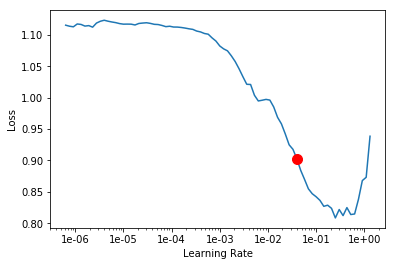

In [17]:
learn.lr_find()
learn.recorder.plot()

Progressively train then unfreeze our classifier layers

In [18]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.369613,0.093900,0.969990


In [19]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy
1,0.192582,0.057394,0.983543


In [20]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy
1,0.160865,0.041426,0.989351
2,0.146002,0.039973,0.989351
3,0.106152,0.030156,0.992256
4,0.091436,0.031186,0.988383
5,0.072513,0.030448,0.990319


In [21]:
learn.save('val-codes-000')

### Predictions

In [23]:
learn.predict("VK: 60679 - код для создания нового приложения.")

(Category verification,
 tensor(2),
 tensor([7.9394e-06, 3.7606e-05, 9.9995e-01]))

In [24]:
learn.predict("imo verification code: 3374")

(Category verification,
 tensor(2),
 tensor([8.4136e-10, 3.6876e-08, 1.0000e+00]))

In [25]:
learn.predict("8866 (WeChat Verification Code)")

(Category verification,
 tensor(2),
 tensor([7.6349e-08, 1.2102e-06, 1.0000e+00]))

In [26]:
learn.predict("Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or �1000. To claim txt DIS to 87121")

(Category spam, tensor(1), tensor([9.7228e-03, 9.9022e-01, 5.3909e-05]))

In [28]:
learn.predict("Hey Mom, what's for supper?")

(Category good, tensor(0), tensor([9.9436e-01, 5.0179e-03, 6.1848e-04]))

In [40]:
learn.predict("Text WIN to 4465 NOW for this limited time offer!")

(Category spam, tensor(1), tensor([0.0748, 0.9241, 0.0011]))

In [42]:
learn.predict("Hey I can offer you 500 for that NOW, limited time offer though, text me soon")

(Category good, tensor(0), tensor([0.8699, 0.1289, 0.0012]))

### Export the model

In [36]:
learn.export()